# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity
- Linear Mapping (to 4D, 5D, 6D, 7D)
- Spirals
- Patches
- Injective Neural Network as a data generating process

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly

In [236]:
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

batch_size = 4096
kappa = 8
iterations = 3000
tau = kappa

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

Using device: cuda


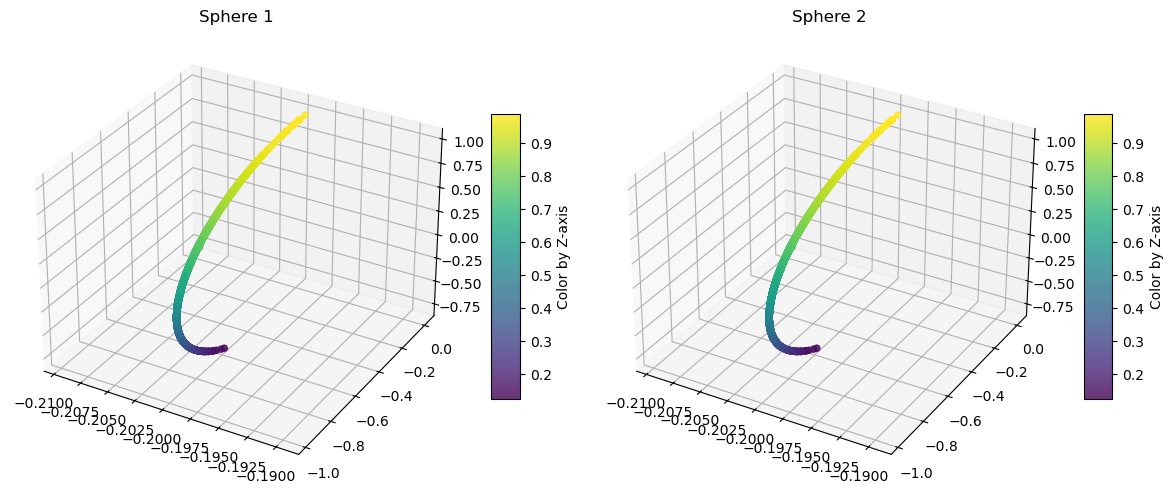

In [237]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

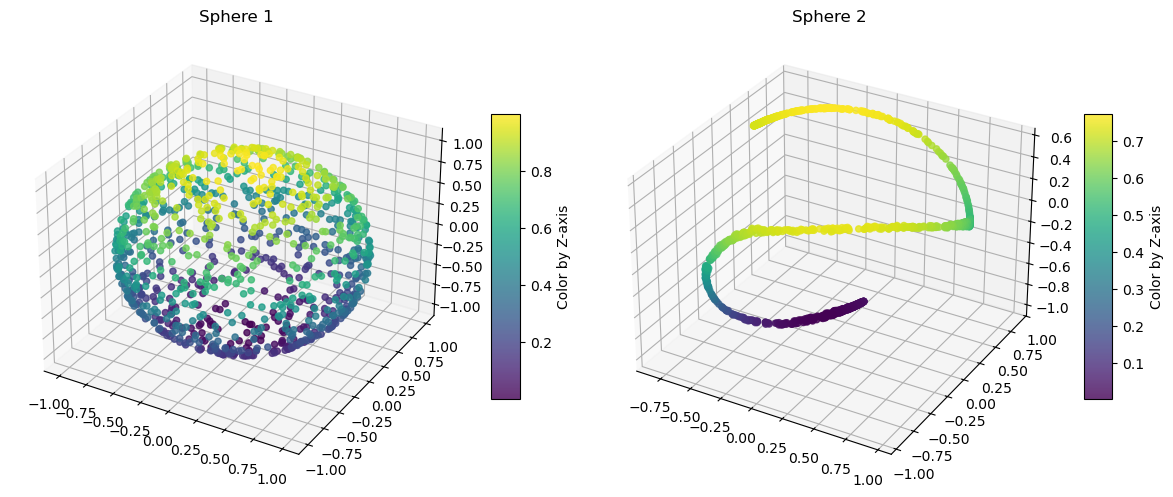

In [240]:
# Initialize the multi-layer perceptron used for encoding
f_constrained = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

h_constrained = lambda z: f_constrained(g_id(z))

simclr_vmf = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau
)

f_constrained = simclr_vmf.train(batch_size, iterations)

z = full_sphere.uniform(1000)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)